In [1]:
import gunpowder as gp
import numpy as np
import zarr
import matplotlib.pyplot as plt
import math

In [125]:
def imshowPair(img1, img2):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img1)
    ax[1].imshow(img2)

def imshow(*args, n=5, figurezize=(10, 4)):
    num_args = len(args)
    plt.figure(figsize=figurezize)
    for row_idx, image_set in enumerate(args): 
        image_set = np.array(image_set)
        n = min(n, image_set.shape[0])
        for col_idx in range(n):
            ax = plt.subplot(num_args, n, row_idx * n + col_idx + 1)
            plt.imshow(image_set[col_idx], cmap='gray')
            plt.axis('off')
    plt.show()


In [25]:
pathZarr = "/mnt/efs/shared_data/restorators/monalisa_data/Actin_20nmScanStep/dataC.zarr"
data = zarr.open(pathZarr, mode='r')
data.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='gt', nodes=(Node(disabled=True, ico…

In [64]:
class OffsectNegative(gp.BatchFilter):

  def __init__(self, array):
    self.array = array

  def process(self, batch, request):

    data = batch[self.array].data
    batch[self.array].data = data - np.min(data)

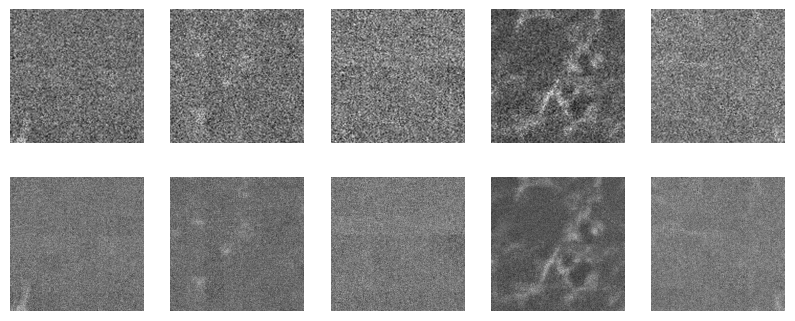

In [143]:
raw = gp.ArrayKey('RAW')
gt = gp.ArrayKey('GT')

source = gp.ZarrSource(
    pathZarr,
    {
      raw: 'tr/tr000',
      gt: 'gt/gt000'
    },
    {
      raw: gp.ArraySpec(interpolatable=True),
      gt: gp.ArraySpec(interpolatable=False)
    })

request = gp.BatchRequest()
request[raw] = gp.Roi((0, 0), (256, 256))
request[gt] = gp.Roi((0, 0), (256, 256))

pipeline = (
    source
    + gp.RandomLocation()
    + OffsectNegative(raw)
    + gp.Normalize(raw, factor=1.0/65535)
    + OffsectNegative(gt)
    + gp.Normalize(gt, factor=1.0/65535)
    + gp.SimpleAugment()
    # + gp.IntensityAugment(
    #   raw,
    #   scale_min=0.8,
    #   scale_max=1.2,
    #   shift_min=-0.2,
    #   shift_max=0.2)
    + gp.Stack(5)
    + gp.Stack(2)
)

with gp.build(pipeline):
    batch = pipeline.request_batch(request)

imshow(batch[raw].data[0], batch[gt].data[0], n=5)


In [15]:
sources = tuple( (gp.ZarrSource(
                pathZarr,
                {
                    raw: f'tr/tr{sample:03d}'
                    gt: f'gt/gt{sample:03d}'
                }
                {
                    raw: gp.ArraySpec(interpolatable=True),
                    gt: gp.ArraySpec(interpolatable=False)
                }
)
), gp.ZarrSource(gt)) + MergeProvider()
+
+ gp.RandomLocation()
                for sample in range(5)

                )
sources += gp.RandomProvider()
raw_request = gp.BatchRequest()
raw_request[raw] = gp.Roi((0,0), (256, 256))
with gp.build(sources):
    batch = sources.request_batch(raw_request)
imshowPair(batch[raw].data.squeeze()[0], batch[gt].data.squeeze()[0])

(256, 256)


In [1]:
with gp.build(pipeline):
    batch = pipeline.request_batch(request)

imshowPair(batch[raw].data.squeeze()[0], batch[gt].data.squeeze()[0])

NameError: name 'gp' is not defined